In [2]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [3]:
import os 
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf
import tensorflow.image as tfi
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM
# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.layers import concatenate
from keras.layers import Multiply
from keras.layers import Input


In [4]:
def load_image(image, SIZE):
    image = tf.cast(tfi.resize(img_to_array(load_img(image)), (SIZE, SIZE)), tf.float32)/255.
    return image

def load_images(paths, SIZE, trim=None, channels=3):
  
    if trim is not None:
        paths = paths[:trim]
        images = np.zeros(shape=(len(paths), SIZE, SIZE, channels))

    if channels==3:
        for i, path in enumerate(paths):
            img = load_image(path, SIZE)
            images[i] = img
    elif channels==1:
        for i, path in enumerate(paths):
            img = load_image(path, SIZE)
            images[i] = img[:,:,:1]
    return images

def show_image(image, title=None, cmap=None, alpha=1.0):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None: plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap='jet', alpha=0.2):
    show_image(image)
    show_image(tf.squeeze(mask), cmap=cmap, alpha=alpha)

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive"
"/content/gdrive/MyDrive"

Mounted at /content/gdrive


'/content/gdrive/MyDrive'

In [6]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip \*.zip && *.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
 

In [7]:
root_path = '/content/COVID-19_Radiography_Dataset/COVID/'
image_path = root_path + 'images/'
mask_path = root_path + 'masks/'

image_paths = sorted(glob(image_path + '*.png'))
mask_paths = []
for path in image_paths:
    mask_paths.append(path.replace('images','masks'))

In [8]:
images = load_images(image_paths, SIZE=256, trim=200)
masks = load_images(mask_paths, SIZE=256, trim=200, channels=1)

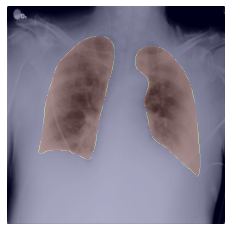

In [9]:
show_mask(images[0], masks[0], alpha=0.2)

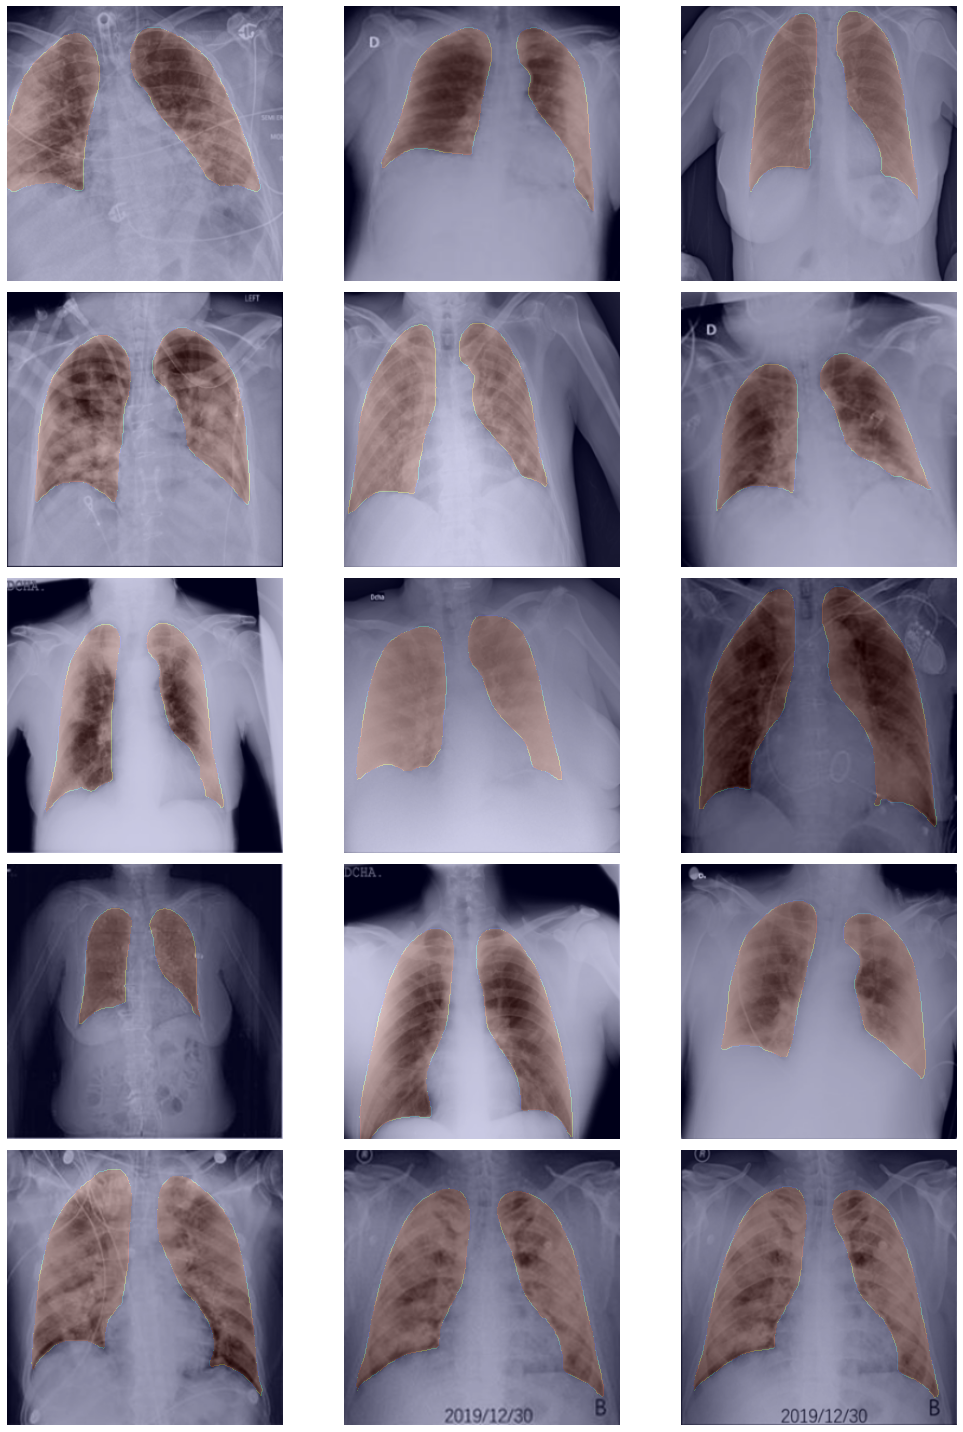

In [10]:
plt.figure(figsize=(15,20))
for i in range(1,16):
    plt.subplot(5,3,i)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id])
plt.tight_layout()
plt.show()

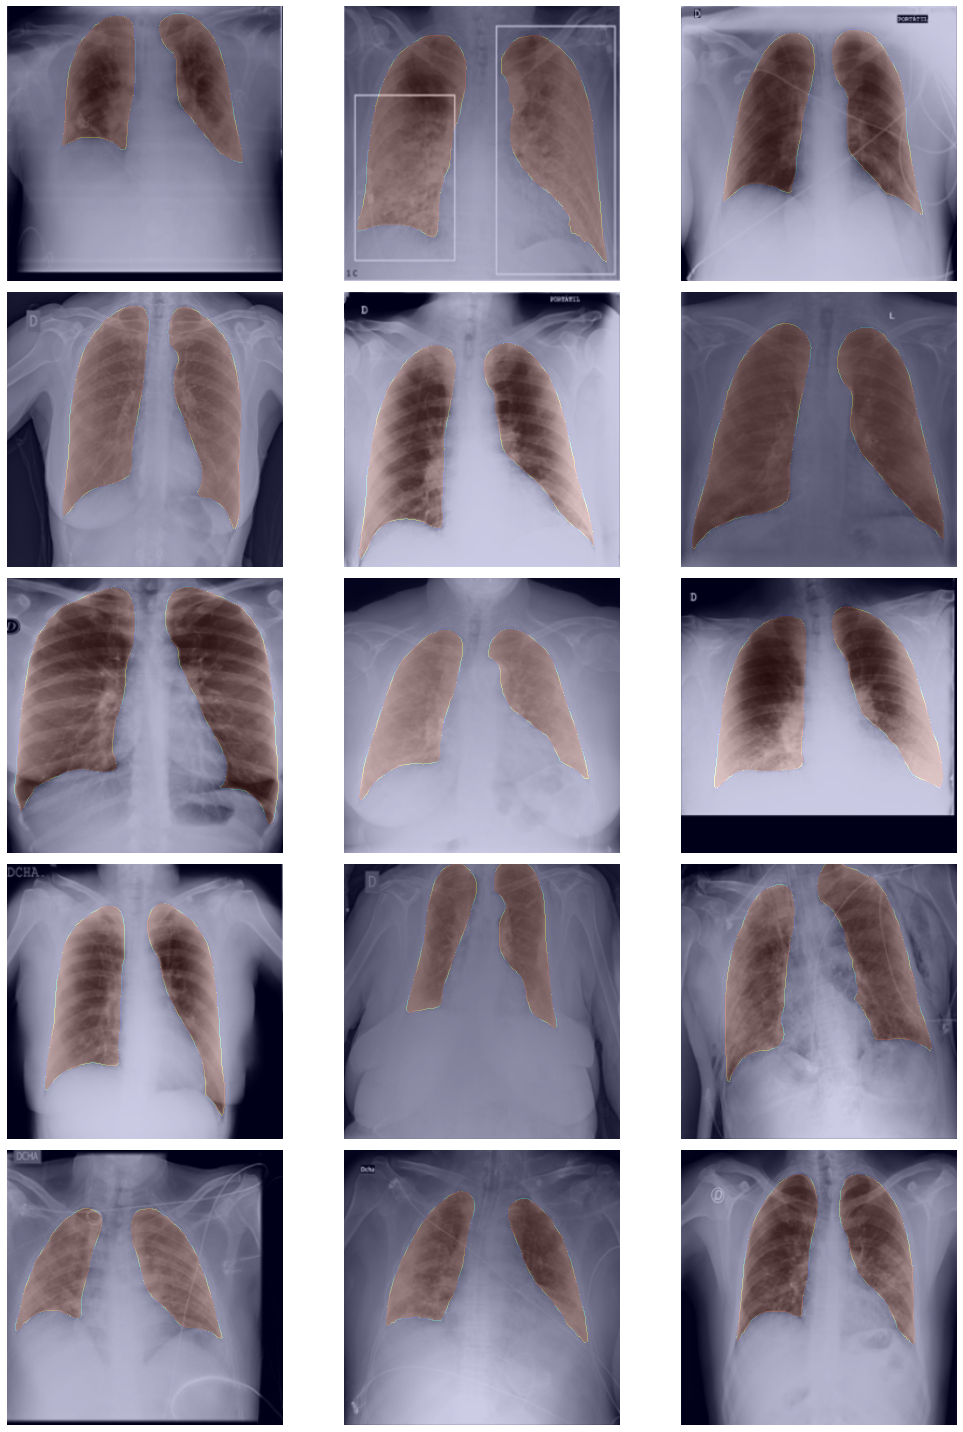

In [11]:
SIZE = 256
images, masks = load_images(image_paths, SIZE, trim=2000), load_images(mask_paths, SIZE, trim=2000, channels=1)
plt.figure(figsize=(15,20))
for i in range(1,16):
    plt.subplot(5,3,i)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id])
plt.tight_layout()
plt.show()

In [12]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'filters':self.filters,
            'rate':self.rate,
            'pooling':self.pooling
            }

In [13]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        x = concatenate([x, skip_X])
        x = self.net(x)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'filters':self.filters,
            'rate':self.rate
            }

In [14]:
class AttentionGate(Layer):

    def __init__(self, filters, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.normal = Conv2D(filters, kernel_size=3, padding='same', kernel_initializer='he_normal', activation='relu')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal', activation='relu')
        self.add = Add()
        self.resample = UpSampling2D()
        self.learn = Conv2D(1,kernel_size=1, padding='same', activation='sigmoid') 
        self.adapt = Multiply()

    def call(self, X):
        X, skip_X = X
        x = self.normal(X)
        skip = self.down(skip_X)
        x = self.add([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = self.adapt([x,skip_X])
        return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'filters':self.filters,
            }

In [15]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])[0]
        cam = GradCAM().explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            model=self.model,
            layer_name='Attention4'
        )

        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask)

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)

        plt.subplot(1,3,3)
        plt.title("Grad CAM")
        show_image(cam)

        plt.tight_layout()
        plt.show()

In [16]:
# Inputs
input_layer = Input(shape=(SIZE, SIZE, 3), name="InputLayer")

# Encoder Network
p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)

# Encoding
c5 = EncoderBlock(512, 0.3, pooling=False, name="EncodingLayer")(p4)

# Attention + Decoder
a1 = AttentionGate(256, name="Attention1")([c5, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([c5, a1])

a2 = AttentionGate(128, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(d4)

# Model
model = Model(inputs=[input_layer], outputs=[output_layer])

# compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name="IoU")]
)

# Callbacks 
cb = [
    ModelCheckpoint('Covid19LungSegmentation.h5', save_best_only=True, monitor='val_loss'),
    ShowProgress()
]

In [17]:
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

Epoch 1/10
1/1 [==============================] - 1s 1s/step


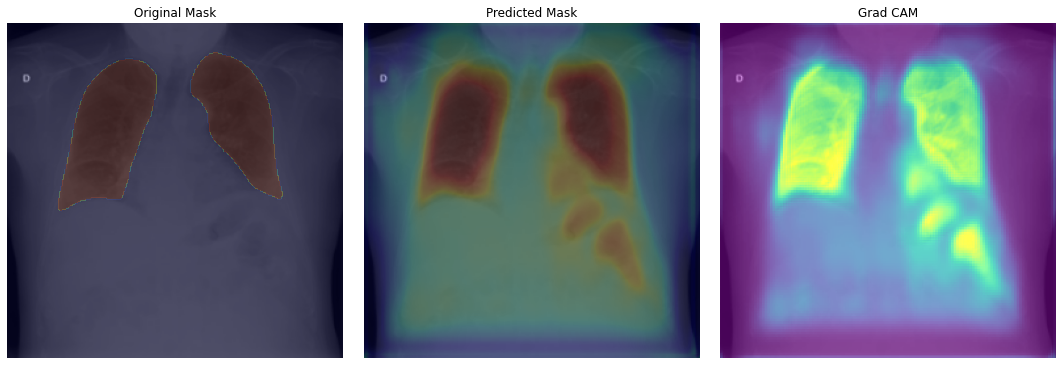

250/250 [==============================] - 89s 293ms/step - loss: 0.4548 - accuracy: 0.8227 - IoU: 0.3764 - val_loss: 0.1752 - val_accuracy: 0.9466 - val_IoU: 0.3875
Epoch 2/10
1/1 [==============================] - 0s 25ms/step


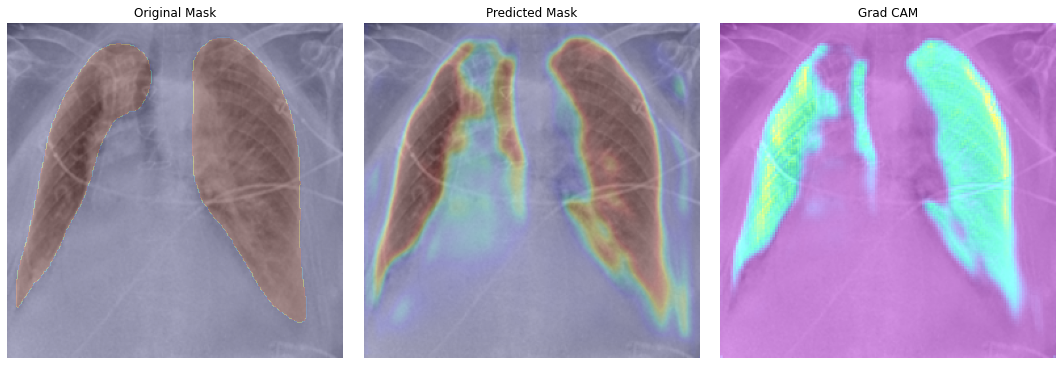

250/250 [==============================] - 63s 253ms/step - loss: 0.1580 - accuracy: 0.9396 - IoU: 0.3773 - val_loss: 0.1007 - val_accuracy: 0.9659 - val_IoU: 0.3875
Epoch 3/10
1/1 [==============================] - 0s 23ms/step


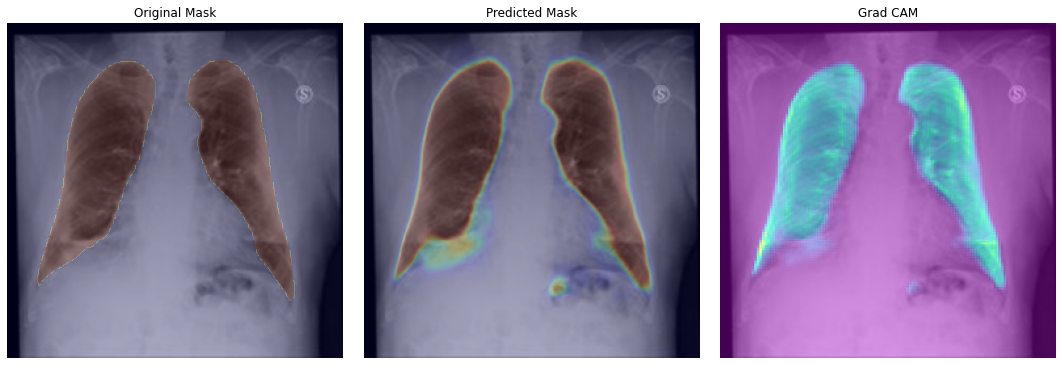

250/250 [==============================] - 65s 259ms/step - loss: 0.1134 - accuracy: 0.9569 - IoU: 0.3797 - val_loss: 0.0717 - val_accuracy: 0.9733 - val_IoU: 0.3875
Epoch 4/10
174/250 [===================>..........] - ETA: 18s - loss: 0.0995 - accuracy: 0.9626 - IoU: 0.3809

In [ ]:
results = model.fit(
    images, masks,
    validation_split=0.1,
    epochs=10,
    steps_per_epoch=SPE,
    callbacks=cb
)

In [ ]:
plt.figure(figsize=(15,20))
n = 0
for i in range(1,21):
    plt.subplot(5,4,i)

    if n==0:
        id = np.random.randint(len(images))
        image, mask = images[id], masks[id]
        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        pred_mask = model.predict(image[np.newaxis,...])[0]
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        id = np.random.randint(len(images))
        image, mask = images[id], masks[id]
        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==3:
        pred_mask = model.predict(image[np.newaxis,...])[0]
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [ ]:
#showing results and model accuracy 
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']
#epochs=30
epochs_range = range(10)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Burda bi sıkıntı var

image_pathse = sorted(glob('/content/xrays/' + '*.jpeg'))
imsf = load_images(image_pathse, SIZE=256, trim=200)
print(len(imsf))

plt.figure(figsize=(15,20))
n = 0
for x in imsf:
  plt.subplot(5,4,2)
  pred_mask = model.predict(imsf)[n]
  plt.title("Predicted Mask")
  show_mask(x, pred_mask)
  n+=1
    
plt.tight_layout()
plt.show()